In [97]:
print("Preparing environment...")

import platform

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import scipy as sp
from astropy import table as tbl
from astropy import units as u
from astropy.io import fits
from astropy import constants as c
from scipy import interpolate
from tqdm.auto import tqdm
from itertools import chain
import os

# %matplotlib widget
plt.rcParams["savefig.facecolor"] = "w"

print("Done.")

Preparing environment...
Done.


In [2]:
### All functions


# Function to parse tables and set any rows with NaNs to zero, to avoid errors
def RemoveNaNs(tableObj):
    for col in tableObj.colnames:
        for x in range(0, len(tableObj[col]), 1):
            if np.isnan(tableObj[col][x]):
                tableObj[col][x] = 0
    return tableObj


# Function to use appropriate OS directory structure
def GetDirStruct():
    match platform.system():
        case "Windows":
            dirPrefix = "D:/"
        case "Linux" | "Ubuntu":
            dirPrefix = "/mnt/d/"
        case "macOS" | "Darwin":
            dirPrefix = "/Volumes/Storage/"
        case _:
            raise Exception(
                f'OS not recognised: "{platform.system()}". Please define a custom switch inside GetDirStruct().'
            )
    return dirPrefix


# Function to grab list of spectra in a directory
def GetSpec():
    dirPrefix = GetDirStruct()
    specDir = dirPrefix + specFolder
    specList = !bash -c "ls {specDir}*1D.fits"
    specList = [file.split("/")[-1] for file in specList]
    specNames = [file.split("_")[0] for file in specList]
    return specDir, specList, specNames


# Function to import files to dictionary
def ImportSpec(specDir, specList, specNames):
    specData = {}
    for file, name in tqdm(list(zip(specList, specNames)), desc="Importing spectra"):
        specRaw = fits.open(specDir + file)
        specFlux = specRaw[1].data * (u.W / u.m**3)
        specErr = specRaw[2].data * (u.W / u.m**3)
        specWave = specRaw[9].data * u.m
        specData[name] = tbl.QTable(
            [specWave, specFlux, specErr], names=("Wavelength", "Flux", "Error")
        )
        specData[name] = RemoveNaNs(specData[name])
        specRaw.close()
    return specData


# Function to plot the spectra
def PlotSpec(specData, specList, specNames):
    !bash -c "mkdir -p ../../Working_Directory/Apo_Phot_Utils/{outputFolder}/plots/spectra/"
    for file, name in tqdm(
        zip(specList, specNames), desc="Plotting spectra", total=len(specList)
    ):
        plt.plot(specData[name]["Wavelength"], specData[name]["Flux"])
        plt.xscale("log")
        plt.savefig(
            f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}plots/spectra/{name}.png"
        )
        plt.close()
    return


# Function to grab list of filter curves
def GetFilter():
    dirPrefix = GetDirStruct()
    filterDir = dirPrefix + filterFolder
    filterList = !bash -c "ls {filterDir}"
    filterList = [file.split("/")[-1] for file in filterList]
    filterNames = [file.split("_")[0] for file in filterList]
    return filterDir, filterList, filterNames


# Function to import filters to a dictionary
def ImportFilter(filterDir, filterList, filterNames):
    filterData = {}
    for file, name in tqdm(
        zip(filterList, filterNames), desc="Importing filters", total=len(filterList)
    ):
        filterData[name] = tbl.QTable.read(filterDir + file, format="ascii")
        filterData[name]["Microns"].unit = u.um
        filterData[name].rename_column("Microns", "Wavelength")
        filterData[name]["Throughput"].unit = u.dimensionless_unscaled
        filterData[name] = RemoveNaNs(filterData[name])
    return filterData


# Function to interpolate datapoints
def InterpFunc(funcXs, funcYs):
    return interpolate.interp1d(funcXs, funcYs, kind="cubic")


# Function to find grid overlap for convolutions of target using input
def FindGrid(targetGrid, inputGrid, inputData):
    # Sort all arrays
    idxSorted = np.argsort(inputGrid)
    sortedGrid = inputGrid[idxSorted]
    sortedTarget = np.sort(targetGrid)
    # Find first value in input that overlaps with target
    if sortedGrid[0] < sortedTarget[0]:
        idxLeft = np.searchsorted(sortedGrid, sortedTarget[0], side="right")
        if inputGrid[idxLeft - 1] == sortedTarget[0]:
            idxLeft -= 1
    else:
        idxLeft = 0
    # Find last value in input that overlaps with target
    if sortedGrid[-1] > sortedTarget[-1]:
        idxRight = np.searchsorted(sortedGrid, sortedTarget[-1], side="left")
        if inputGrid[idxRight] != sortedTarget[-1]:
            idxRight -= 1
    else:
        idxRight = -1
    # Return the section of input that overlaps target
    overlapGrid = sortedGrid[idxLeft:idxRight]
    overlapData = inputData[idxSorted][idxLeft:idxRight]
    return overlapGrid, overlapData


# Function to manage convolution calculation from first array onto second array
def ConvolveFunc(firstXs, firstYs, secondXs, secondYs):
    # Interpolate datapoints of first array
    firstInterp = InterpFunc(firstXs.to(u.m), firstYs)
    # Find portion of relevant convolution grid for first array based on second array
    secondOverlapGrid, secondOverlapData = FindGrid(firstXs, secondXs, secondYs)
    # Convolve first array onto second array's grid
    firstConvolved = firstInterp(secondOverlapGrid.to(u.m)) * firstYs.unit
    return firstConvolved, secondOverlapGrid, secondOverlapData


# Function to convolve spectra and filters onto same grid
def MergeGrids(specFile, filterFile):
    # Find mutual overlaps
    specConvolved, filterOverlapGrid, filterOverlapData = ConvolveFunc(
        specFile["Wavelength"],
        specFile["Flux"],
        filterFile["Wavelength"],
        filterFile["Throughput"],
    )
    filterConvolved, specOverlapGrid, specOverlapData = ConvolveFunc(
        filterFile["Wavelength"],
        filterFile["Throughput"],
        specFile["Wavelength"],
        specFile["Flux"],
    )
    # Save as tables
    specTable = tbl.QTable(
        [
            np.append(specOverlapGrid, filterOverlapGrid).to(u.m),
            np.append(specOverlapData, specConvolved),
        ],
        names=("Wavelength", "Flux"),
    )
    specTable.sort("Wavelength")
    filterTable = tbl.QTable(
        [
            np.append(filterOverlapGrid, specOverlapGrid).to(u.m),
            np.append(filterOverlapData, filterConvolved),
        ],
        names=("Wavelength", "Throughput"),
    )
    filterTable.sort("Wavelength")
    # Join tables
    mergedTable = tbl.join(specTable, filterTable, keys="Wavelength")
    # Include error table only for spectral grid (errors should not be interpolated onto filter grid)
    filterConvolvedErr, errOverlapGrid, errOverlapData = ConvolveFunc(
        filterFile["Wavelength"],
        filterFile["Throughput"],
        specFile["Wavelength"],
        specFile["Error"],
    )
    errorTable = tbl.QTable(
        [errOverlapGrid.to(u.m), errOverlapData, filterConvolvedErr],
        names=("Wavelength", "Error", "Throughput"),
    )
    return mergedTable, errorTable


# Function to shift flux to photon space
def ShiftPhotonSpace(tableFlux, tableWave):
    tableFlux *= tableWave / (c.h * c.c)
    return


# Function to calculate throughput on a merged grid
def CalcThroughput(firstYs, secondYs, commonGrid, errYs=None, errY2s=None, errGrid=None):
    combinedYs = firstYs * secondYs
    # Trapezoidal rule: SUM( 1/2 * (f(a) + f(b)) * (b - a) )
    specThrough = np.sum(
        (combinedYs + np.roll(combinedYs, 1))[1:]
        / 2
        * (commonGrid - np.roll(commonGrid, 1))[1:]
    )
    # Error propagation: SQRT( SUM( ( SQRT( (df(a)^2 + df(b)^2) / 2 ) * (b - a) )^2 ) )
    # Note that the 1/2 is inside the square root. This seems to stem from Pooled Variance
    # estimates in statistics. See [https://en.wikipedia.org/wiki/Pooled_variance].
    # This is the only way to obtain SNRs that match crude estimates.
    # See also [https://en.wikipedia.org/wiki/Propagation_of_uncertainty] and the
    # arithmetic mean.
    if errYs == errY2s == errGrid == None:
        errThrough = None
    else:
        combinedErrs = errYs * errY2s
        errThrough = np.sqrt(
            np.sum(
                (
                    np.sqrt((combinedErrs**2 + np.roll(combinedErrs**2, 1))/2)[1:]
                    * (errGrid - np.roll(errGrid, 1))[1:]
                )
                ** 2
            )
        )
    return specThrough, errThrough
    # return np.trapz(firstYs * secondYs, x=commonGrid) # * (firstYs.unit * secondYs.unit * commonGrid.unit)


# Function to find throughput given a spectrum and filter
def FindThroughput(specFile, filterFile):
    # Convolve onto the same grid
    mergedTable, errorTable = MergeGrids(specFile, filterFile)
    # Shift to photon space
    ShiftPhotonSpace(mergedTable["Flux"], mergedTable["Wavelength"])
    ShiftPhotonSpace(errorTable["Error"], errorTable["Wavelength"])
    # Integrate through the filter
    specThrough, errThrough = CalcThroughput(
        mergedTable["Flux"],
        mergedTable["Throughput"],
        mergedTable["Wavelength"],
        errorTable["Error"],
        errorTable["Throughput"],
        errorTable["Wavelength"],
    )
    return specThrough.to(1/u.cm**2 / u.s), mergedTable, errThrough.to(1/u.cm**2 / u.s), errorTable


# Function to grab central wavelength of filter
def FindCentral(filterWave, filterThrough):
    return np.average(
        filterWave, weights=filterThrough
    )  # Weighted by throughput, not all wavelengths contribute equally


# Function to normalise the throughput to the correct zero-point
def NormaliseValue(specTable, specValue, filterFile):
    specThrough = specTable["Throughput"]
    specGrid = specTable["Wavelength"]
    # norm_ref = 10**(48.6/(-2.5)) # reference zero magnitude
    normRef = 1 * u.Jy  # * 10**(-9) # reference flat-value in f_nu
    normYs = (normRef * c.c / specGrid**2).to(
        u.erg / u.cm**2 / u.s / u.angstrom
    )  # reference flat-value in wavelength space
    ShiftPhotonSpace(normYs, specGrid) # reference flat-value in photon space
    normValue = (
        CalcThroughput(specThrough, normYs, specGrid)[0].to(specValue.unit)
    )  # magnitude of normalisation factor
    specNormed = ((specValue / normValue) * u.Jy).to(u.nJy)  # throughput returned to Jy in wavelength space
    return specNormed


def BalmerBreak(specFile, specName, redshiftFile):
    # Define regions
    balmerLeftRange = np.array([3500, 3650]) * u.angstrom
    balmerRightRange = np.array([3800, 3950]) * u.angstrom
    # Grab relevant grids
    for row in range(0, len(redshiftFile), 1):
        if (
            int(specName) == int(redshiftFile[row][redshiftID])
            and redshiftFile[row][redshiftZ] > 0
        ):
            redshiftFactor = 1 + redshiftFile[row][redshiftZ]
            break
        else:
            redshiftFactor = np.nan
    if redshiftFactor != 0:
        balmerLeftWave, balmerLeftSpec = FindGrid(
            balmerLeftRange,
            specFile["Wavelength"] / redshiftFactor,
            specFile["Flux"] * redshiftFactor,
        )
        _, balmerLeftErr = FindGrid(
            balmerLeftRange,
            specFile["Wavelength"] / redshiftFactor,
            specFile["Error"] * redshiftFactor,
        )
        balmerLeftTable = tbl.QTable(
            [balmerLeftWave, balmerLeftSpec, balmerLeftErr],
            names=("Wavelength", "Flux", "Error"),
        )
        balmerRightWave, balmerRightSpec = FindGrid(
            balmerRightRange,
            specFile["Wavelength"] / redshiftFactor,
            specFile["Flux"] * redshiftFactor,
        )
        _, balmerRightErr = FindGrid(
            balmerRightRange,
            specFile["Wavelength"] / redshiftFactor,
            specFile["Error"] * redshiftFactor,
        )
        balmerRightTable = tbl.QTable(
            [balmerRightWave, balmerRightSpec, balmerRightErr],
            names=("Wavelength", "Flux", "Error"),
        )
        # Shift to photon space
        ShiftPhotonSpace(balmerLeftTable["Flux"], balmerLeftTable["Wavelength"])
        ShiftPhotonSpace(balmerLeftTable["Error"], balmerLeftTable["Wavelength"])
        ShiftPhotonSpace(balmerRightTable["Flux"], balmerRightTable["Wavelength"])
        ShiftPhotonSpace(balmerRightTable["Error"], balmerRightTable["Wavelength"])
        # Calculate average flux
        balmerLeftVal = np.sum(balmerLeftTable["Flux"]) / len(balmerLeftTable["Flux"])
        balmerRightVal = np.sum(balmerRightTable["Flux"]) / len(
            balmerRightTable["Flux"]
        )
        # Calculate ratio
        balmerRatio = balmerRightVal / balmerLeftVal
        balmerVals = [balmerLeftVal, balmerRightVal, balmerRatio]
    return balmerVals


# Function to loop through filters and balmer breaks for one spectrum
def HandleSpectrum(specFile, specName, filterData, redshiftFile):
    specValues = []
    for filterFile in filterData.values():
        specValue, specTable, errValue, errTable = FindThroughput(specFile, filterFile)
        specValues += [
            NormaliseValue(specTable, specValue, filterFile),
            NormaliseValue(errTable, errValue, filterFile),
        ]
    specValues += BalmerBreak(specFile, specName, redshiftFile)
    return specValues


# Function to loop through each spectrum and save values to a table
def LoopSpectra(specData, filterData, redshiftFile):
    !bash -c "mkdir -p ../../Working_Directory/Apo_Phot_Utils/{outputFolder}"
    rows = []
    for specName, specFull in tqdm(
        zip(specData.keys(), specData.values()),
        desc="Calculating throughputs",
        total=len(specData.keys()),
    ):
        rows += [
            [int(specName)]
            + HandleSpectrum(specFull, specName, filterData, redshiftFile)
        ]
    names = (
        ["ID"]
        + list(
            chain.from_iterable(
                [
                    [key + " Throughput", key + " Throughput Error"]
                    for key in filterData.keys()
                ]
            )
        )
        + ["Balmer_left", "Balmer_right", "Balmer_ratio"]
    )
    outTable = tbl.Table(rows=rows, names=names)
    outTable.sort("ID")
    outTable.write(
        f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}/throughputs.fits",
        overwrite=True,
    )
    return outTable


# Function to import photometry files
def ImportPhot():
    photList = !bash -c "ls -1 {photDir}/FilterData/*_summary.fits | xargs -n 1 basename"
    photList = [file.split("/")[-1] for file in photList]
    photTables = {}
    for file in tqdm(photList, desc="Importing apodised fluxes"):
        pointingNum = int(file.split("_")[0])
        photTables[pointingNum] = tbl.QTable.read(f"{photDir}/FilterData/{file}")
    return photTables


# Function to import Astrometry
def ImportAstro():
    astroTables = {}
    dirPrefix = GetDirStruct()
    for slit, point in tqdm(
        list(zip(slitNums, pointNums)), desc="Importing astrometry"
    ):
        sourceList = tbl.QTable.read(
            f"{dirPrefix}/Astrometry/{astroDir}/{pointFolder}/{pointPrefix}{point}{pointSuffix}",
            format="ascii",
        )
        sourceAstro = tbl.QTable.read(
            f"{dirPrefix}/Astrometry/{astroDir}/{slitFolder}/{slitPrefix}{slit}{slitSuffix}",
            format="ascii",
        )
        astroTables[point] = tbl.join(sourceList, sourceAstro, keys="ID")
        astroTables[point]["Source_RA"].unit = u.degree
        astroTables[point]["Source_Dec"].unit = u.degree
    return astroTables


# Function to grab list of slitloss corrections
def GrabSlitloss():
    lossDir = GetDirStruct() + lossFolder
    lossList = {}
    for lossPoint in tqdm(lossPoints, desc="Identifying available slitlosses"):
        lossList[lossPoint] = {}
        for lossExp in tqdm(lossExps, desc="Pointings", leave=False):
            lossNames = !bash -c "ls {lossDir}/{lossPoint}/{lossPrefix01}{lossPoint}_{lossExp}{lossPrefix02}*{lossSuffix}"
            lossNames = [
                f"{file.split('/')[-2]}/{file.split('/')[-1]}" for file in lossNames
            ]
            lossIDs = [
                int(file.split("_")[-3].split("idcat")[-1]) for file in lossNames
            ]
            lossList[lossPoint][lossExp] = tbl.Table(
                [lossIDs, lossNames], names=("ID", "Name")
            )
    return lossDir, lossList


# Function to import slitloss corrections
def ImportSlitloss(lossDir, lossList, photTables):
    lossData = {}
    for pointNum, pointName in tqdm(
        list(zip(pointNums, lossPoints)), desc="Importing slitlosses"
    ):
        IDList = tbl.Table([photTables[pointNum]["ID"]])
        lossData[pointName] = {}
        for lossExp in tqdm(
            lossList[pointName].keys(), desc="Parsing exposures", leave=False
        ):
            lossData[pointName][lossExp] = {}
            lossData[pointName][lossExp]["Index"] = tbl.join(
                lossList[pointName][lossExp], IDList, keys="ID"
            )
            for row in tqdm(
                range(0, len(lossData[pointName][lossExp]["Index"]), 1),
                desc="Matching IDs",
                leave=False,
            ):
                galID = lossData[pointName][lossExp]["Index"][row]["ID"]
                galName = lossData[pointName][lossExp]["Index"][row]["Name"]
                lossData[pointName][lossExp][galID] = tbl.QTable.read(
                    lossDir + galName, format="ascii"
                )
                lossData[pointName][lossExp][galID].rename_column("col1", "Slitloss")
                lossData[pointName][lossExp][galID].rename_column("col2", "Wavelength")
                lossData[pointName][lossExp][galID][
                    "Slitloss"
                ].unit = u.dimensionless_unscaled
                lossData[pointName][lossExp][galID]["Wavelength"].unit = u.um
            del lossData[pointName][lossExp]["Index"]
    return lossData

# Function to calculate photometry ratios
def CalcSlitRatio(photTable, specTable, pointNum):
    combTable = tbl.join(photTable, specTable, keys="ID")
    fluxCols = [colname for colname in combTable.colnames if "Actual Flux" in colname and "Density" not in colname]
    fluxErrCols = [colname for colname in combTable.colnames if "Flux Error" in colname]
    # throughCols = combTable.colnames[firstThrough::2]
    throughCols = [colname for colname in combTable.colnames if "Throughput" in colname and "Error" not in colname]
    throughErrCols = [colname for colname in combTable.colnames if "Throughput Error" in colname]
    ratioTable = tbl.QTable([combTable["ID"]])
    fluxNames = []
    # Eliminating nonsensical results from calculations
    for col in fluxCols + fluxErrCols + throughCols + throughErrCols:
        combTable[col] = np.where(combTable[col] > 0, combTable[col], np.nan)
    # 5 sigma selection criteria
    SNRCounts = []
    for gal in range(0, len(combTable), 1):
        SNRCount = 0
        for flux, fluxErr in list(zip(fluxCols, fluxErrCols)):
            if combTable[flux][gal] / combTable[fluxErr][gal] > 5.0:
                SNRCount += 1
        SNRCounts += [SNRCount]
    combTable.add_column(SNRCounts, name="Total High SNR Bands")
    plt.close("all")
    counts, bins = np.histogram(combTable["Total High SNR Bands"], bins=len(fluxCols))
    plt.hist(bins[:-1], bins, weights=counts, density=True, cumulative=True)
    plt.savefig(f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}/plots/SNRcriteria/cumulativeSNR_{pointNum}.png")
    plt.close()
    for fluxCol, fluxErrCol in list(zip(fluxCols, fluxErrCols)):
        fluxName = fluxCol.split()[0]
        for throughCol, throughErrCol in list(zip(throughCols, throughErrCols)):
            throughName = throughCol.split()[0]
            if fluxName == throughName:
                ratioTable.add_columns(
                    [
                        combTable[fluxCol],
                        combTable[throughCol],
                        combTable[fluxCol] / combTable[throughCol],
                        combTable[fluxCol] / combTable[throughCol] * np.sqrt( (combTable[fluxErrCol]/combTable[fluxCol])**2 + (combTable[throughErrCol]/combTable[throughCol])**2 ),
                    ],
                    names=(
                        fluxCol,
                        throughCol,
                        f"{fluxName} Ratio",
                        f"{fluxName} Ratio Error",
                    ),
                )
                fluxNames += [fluxName]
    ratioTable.add_column(combTable["Total High SNR Bands"])
    ratioTable.sort("ID")
    ratioTable.write(
        f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}/RawOutput/ratios_{pointNum}.fits",
        overwrite=True,
    )
    return ratioTable, fluxNames


# Function to calculate slit-losses at centre of filters
def CalcLossTable(lossData, fluxNames, lossTables, pointName):
    lossTables[pointName] = {}
    for exposure in lossData.keys():
        rows = []
        for galaxy in lossData[exposure].keys():
            row = []
            row += [galaxy]
            lossInterpolated = interpolate.interp1d(
                lossData[exposure][galaxy]["Wavelength"],
                lossData[exposure][galaxy]["Slitloss"],
            )
            for fluxName in fluxNames:
                centralWave = float(fluxName[1] + "." + fluxName[2:4]) * u.um
                centralLoss = lossInterpolated(centralWave)
                row += [1 / centralLoss * u.dimensionless_unscaled]
            rows += [row]
        names = ["ID"] + [f"{fluxName} slitloss" for fluxName in fluxNames]
        lossTables[pointName][exposure] = tbl.QTable(rows=rows, names=names)
    return lossTables


# Function to calculate slit-loss factor between photometry and model
def CalcDiffTable(ratioTable, lossTables, pointName):
    diffTable = tbl.QTable([ratioTable["ID"],ratioTable["Total High SNR Bands"]])
    for exposure in lossTables.keys():
        matchedTable = tbl.join(ratioTable, lossTables[exposure], keys="ID")
        firstRatio = 3
        firstLoss = len(ratioTable.colnames)
        ratioNames = matchedTable.colnames[firstRatio:firstLoss:4]
        lossNames = matchedTable.colnames[firstLoss:]
        tempTable = tbl.QTable([matchedTable["ID"],matchedTable["Total High SNR Bands"]])
        for ratioName in ratioNames:
            for lossName in lossNames:
                if ratioName.split()[0] == lossName.split()[0]:
                    tempTable.add_columns(
                        [
                            matchedTable[ratioName] / matchedTable[lossName],
                            (matchedTable[f"{ratioName} Error"] / matchedTable[ratioName]) * (matchedTable[ratioName] / matchedTable[lossName])
                        ],
                        names=(
                            f"{ratioName.split()[0]}_{exposure}_Diff",
                            f"{ratioName.split()[0]}_{exposure}_DiffErr"
                        )
                    )
        diffTable = tbl.join(diffTable, tempTable, keys=("ID", "Total High SNR Bands"), join_type="outer")
    diffTable.sort("ID")
    diffTable.write(
        f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}/RawOutput/differences_{pointName}_detailed.fits",
        overwrite=True,
    )
    return diffTable


# Function to append average differences across pointings and exposures
def CalcAverageDiff(diffTable, astroTable, pointName):
    colNames = diffTable.colnames[2::2]
    for i, colName_i in enumerate(colNames):
        stepSize = 0
        for j, colName_j in enumerate(colNames[i + 1 :]):
            if colName_i.split("_")[0] == colName_j.split("_")[0] and colName_i.split("_")[-1] == colName_j.split("_")[-1] == "Diff":
                stepSize = j + 1
                break
        if 0 not in [stepSize]:
            break
    tempTable = tbl.QTable([diffTable["ID"], diffTable["Total High SNR Bands"]])
    for i, colName_i in enumerate(colNames[0 : stepSize : 2]):
        tempCol = diffTable[colName_i].copy()
        tempErr = diffTable[f"{colName_i}Err"].copy()
        count = np.where(tempCol > 0, 1, 0)
        tempErr = np.where(tempCol > 0, tempErr**2, np.nan)
        for j, colName_j in enumerate(
            colNames[i + stepSize :: stepSize]
        ):
            tempCol += diffTable[colName_j]
            tempErr += np.where(diffTable[colName_j] > 0, diffTable[f"{colName_j}Err"]**2, np.nan)
            count += np.where(diffTable[colName_j] > 0, 1, 0)
        count = np.where(count > 0, count, np.nan)
        tempTable.add_columns(
            [
                tempCol / count,
                np.sqrt(tempErr) / np.sqrt(count)
            ],
            names=(
                f"{colName_i.split('_')[0]}_Diff",
                f"{colName_i.split('_')[0]}_DiffErr"
            )
        )
    diffTable = tbl.join(tempTable, astroTable, keys="ID", join_type="left")
    diffTable.sort("ID")
    diffTable.write(
        f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}differences_{pointName}.fits",
        overwrite=True,
    )
    return diffTable

# Function to handle slit-losses
def HandleSlitloss(lossData, photTables, astroTables, specTable):
    !bash -c "mkdir -p ../../Working_Directory/Apo_Phot_Utils/{outputFolder}/RawOutput/"
    !bash -c "mkdir -p ../../Working_Directory/Apo_Phot_Utils/{outputFolder}/plots/SNRcriteria/"
    lossTables = {}
    diffTables = {}
    ratioTables = {}
    for pointNum, pointName in tqdm(
        list(zip(pointNums, lossPoints)), desc="Calculating difference factors"
    ):
        ratioTable, fluxNames = CalcSlitRatio(photTables[pointNum], specTable, pointNum)
        lossTables = CalcLossTable(
            lossData[pointName], fluxNames, lossTables, pointName
        )
        diffTable = CalcDiffTable(ratioTable, lossTables[pointName], pointName)
        diffTable = CalcAverageDiff(diffTable, astroTables[pointNum], pointName)
        diffTables[pointNum] = diffTable
        ratioTables[pointNum] = ratioTable
    return ratioTables, lossTables, diffTables

In [160]:
# Function to import difference factors
def ImportDiff():
    diffTables = {}
    # diffList = !bash -c "ls ../../Working_Directory/Apo_Phot_Utils/{outputFolder}/differences*.fits | grep -v \"detailed.fits\""
    for pointName, pointNum in list(zip(lossPoints, pointNums)):
        for file in diffList:
            if file.split("/")[-1].split("_")[-1].split(".fits")[0] == pointName:
                diffTables[pointNum] = tbl.QTable.read(file)
    return diffTables


# Function to plot all difference factors by RA/Dec
def PlotDiffCoords(diffTables):
    print("Plotting coordinates...")
    for pointName, pointNum in tqdm(list(zip(lossPoints, pointNums)), desc="Pointings"):
        !bash -c "mkdir -p ../../Working_Directory/Apo_Phot_Utils/{outputFolder}/plots/RA_Dec/"
        colIndices = np.arange(
            diffTables[pointNum].colnames.index("Total High SNR Bands") + 1,
            diffTables[pointNum].colnames.index("Source_RA"),
        )
        colNames = diffTables[pointNum].colnames[colIndices[0] : colIndices[-1] : 2]
        errNames = diffTables[pointNum].colnames[colIndices[0] + 1 : colIndices[-1] + 1 : 2]
        for plotCoord in tqdm(["RA", "Dec"], desc="Coordinates", leave=False):
            for plotLog in tqdm(["lin", "log"], desc="Plots", leave=False):
                allCols = colIndices[0::2]
                cmap = mpl.colormaps["jet_r"]
                norm = mpl.colors.Normalize(vmin=min(allCols), vmax=max(allCols))
                for galaxy in tqdm(
                    range(0, len(diffTables[pointNum]["ID"]), 1),
                    desc="Galaxies",
                    leave=False,
                ):
                    if diffTables[pointNum]["Total High SNR Bands"][galaxy] >= 2:
                        allPos = np.array([diffTables[pointNum][f"Source_{plotCoord}"][galaxy].value] * len(colNames))
                        allVals = np.array(list(diffTables[pointNum][colNames][galaxy]))
                        allErrs = np.array(list(diffTables[pointNum][errNames][galaxy]))
                        validCols = allCols[~np.isnan(allVals)]
                        validPos = allPos[~np.isnan(allVals)]
                        validVals = allVals[~np.isnan(allVals)]
                        validErrs = allErrs[~np.isnan(allVals)]
                        plt.scatter(
                            validPos,
                            validVals,
                            c=cmap(norm(validCols)),
                            s=2,
                            zorder=100
                        )
                        plt.errorbar(
                            validPos,
                            validVals,
                            yerr=validErrs,
                            linestyle='',
                            marker=None,
                            ecolor=cmap(norm(validCols)),
                            mew=0,
                            lw=.5,
                            zorder=0
                        )
                cbar=plt.colorbar()
                cbar.set_ticklabels(
                    [colName.split("_")[0] for colName in colNames]
                )
                cbar.ax.set_title("Filter")
                plt.xlabel(f"{plotCoord} ({u.deg})")
                plt.axhline(1)
                plt.ylabel("Difference Factor")
                if plotLog == "lin":
                    plt.ylim(-1, 10)
                elif plotLog == "log":
                    plt.yscale("log")
                    plt.ylim(10 ** (-2), 10**2)
                if plotCoord == "RA":
                    plt.title("Difference Factors vs RA", wrap=True)
                elif plotCoord == "Dec":
                    plt.title("Difference Factors vs Dec", wrap=True)
                plt.savefig(
                    f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}/plots/RA_Dec/{plotCoord}_{plotLog}_byFilter_{pointName}.png",
                    dpi=300,
                )
                # plt.show()
                plt.close()
                allCols = diffTables[pointNum][f"Source_{plotCoord}"]
                cmap = mpl.colormaps["plasma"]
                norm = mpl.colors.Normalize(vmin=min(allCols.value), vmax=max(allCols.value))
                for colName in tqdm(colNames, desc="Filters", leave=False):
                    allPos = np.array([float(colName[1:4]) * 10] * len(diffTables[pointNum]))
                    allVals = diffTables[pointNum][colName]
                    allErrs = diffTables[pointNum][f"{colName}Err"]
                    validPos = allPos[np.where(diffTables[pointNum]["Total High SNR Bands"]>=2)]
                    validVals = allVals[np.where(diffTables[pointNum]["Total High SNR Bands"]>=2)]
                    validErrs = allErrs[np.where(diffTables[pointNum]["Total High SNR Bands"]>=2)]
                    validCols = allCols[np.where(diffTables[pointNum]["Total High SNR Bands"]>=2)]
                    plt.scatter(
                        validPos,
                        validVals,
                        c=cmap(norm(validCols)),
                        s=2,
                    )
                    plt.errorbar(
                        validPos,
                        validVals,
                        yerr=validErrs,
                        linestyle='',
                        marker=None,
                        ecolor=cmap(norm(validCols)),
                        mew=0,
                        lw=.5,
                        zorder=0
                    )
                cbar = plt.colorbar()
                plt.clim(min(allCols.value),max(allCols.value))
                cbar.ax.set_title(f"{plotCoord} ({u.degree})")
                plt.xlabel(f"Wavelength (nm)")
                plt.axhline(1)
                plt.ylabel("Difference Factor")
                if plotLog == "lin":
                    plt.ylim(-1, 10)
                elif plotLog == "log":
                    plt.yscale("log")
                    plt.ylim(10 ** (-2), 10**2)
                if plotCoord == "RA":
                    plt.title("Difference Factors vs Wavelength", wrap=True)
                elif plotCoord == "Dec":
                    plt.title("Difference Factors vs Wavelength", wrap=True)
                plt.savefig(
                    f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}/plots/RA_Dec/{plotCoord}_{plotLog}_byCoord_{pointName}.png",
                    dpi=300,
                )
                # plt.show()
                plt.close()
        for colName in tqdm(colNames, desc="Filters", leave=False):
            raise Exception("You asked me to stop.")
            plt.scatter(
                diffTables[pointNum]["Source_RA"],
                diffTables[pointNum]["Source_Dec"],
                c=np.log10(diffTables[pointNum][colName]),
                cmap="tab20b",
                s=2,
            )
            cbar = plt.colorbar()
            cbar.ax.set_title("Log10(Difference factor)")
            plt.clim(np.log10(0.2), np.log10(5))
            plt.xlabel(f"RA ({u.deg})")
            plt.ylabel(f"Dec ({u.deg})")
            plt.title(f"{colName.split('_')[0]}")
            plt.title(f"RA vs Dec for {colName.split('_')[0]}", wrap=True)
            plt.savefig(
                f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}/plots/RA_Dec/Both_{colName.split('_')[0]}_{pointName}.png",
                dpi=300,
            )
            # plt.show()
            plt.close()
        # plt.show()
    return


# Function to plot all difference factors by offset
def PlotDiffOffsets(diffTables):
    print("Plotting offsets...")
    for pointName, pointNum in tqdm(list(zip(lossPoints, pointNums)), desc="Pointings"):
        !bash -c "mkdir -p ../../Working_Directory/Apo_Phot_Utils/{outputFolder}/plots/offsets/"
        colIndices = np.arange(
            diffTables[pointNum].colnames.index("ID") + 1,
            diffTables[pointNum].colnames.index("Source_RA"),
        )
        colNames = diffTables[pointNum].colnames[colIndices[0] : colIndices[-1]]
        for plotOffset in tqdm(["Offset_x", "Offset_y"], desc="Offsets", leave=False):
            for plotLog in tqdm(["lin", "log"], desc="Plots", leave=False):
                for galaxy in tqdm(
                    range(0, len(diffTables[pointNum]["ID"]), 1),
                    desc="Galaxies",
                    leave=False,
                ):
                    plt.scatter(
                        [diffTables[pointNum][f"{plotOffset}"][galaxy]]
                        * len(colIndices[0:-1]),
                        np.array(list(diffTables[pointNum][colNames][galaxy])),
                        c=colIndices[0:-1],
                        cmap="jet_r",
                        s=2,
                    )
                cbar = plt.colorbar()
                cbar.set_ticklabels(
                    [colName.split("_")[0] for colName in colNames[0:-1]]
                )
                cbar.ax.set_title("Filter")
                if plotOffset == "Offset_x":
                    plt.xlabel("Offset (x)")
                elif plotOffset == "Offset_y":
                    plt.xlabel("Offset (y)")
                plt.axhline(1)
                plt.ylabel("Difference Factor")
                if plotLog == "lin":
                    plt.ylim(-1, 10)
                elif plotLog == "log":
                    plt.yscale("log")
                    plt.ylim(10 ** (-2), 10**2)
                if plotOffset == "Offset_x":
                    plt.title("Difference Factors vs Offset (x)", wrap=True)
                elif plotOffset == "Offset_y":
                    plt.title("Difference Factors vs Offset (y)", wrap=True)
                plt.savefig(
                    f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}/plots/offsets/{plotOffset}_{plotLog}_byFilter_{pointName}.png",
                    dpi=300,
                )
                # plt.show()
                plt.close()
                for colName in tqdm(colNames, desc="Filters", leave=False):
                    plt.scatter(
                        [float(colName[1:4]) * 10] * len(diffTables[pointNum]),
                        diffTables[pointNum][colName],
                        c=diffTables[pointNum][f"{plotOffset}"],
                        cmap="plasma",
                        s=2,
                    )
                cbar = plt.colorbar()
                if plotOffset == "Offset_x":
                    cbar.ax.set_title("Offset (x)")
                elif plotOffset == "Offset_y":
                    cbar.ax.set_title("Offset (y)")
                plt.xlabel(f"Wavelength (nm)")
                plt.axhline(1)
                plt.ylabel("Difference Factor")
                if plotLog == "lin":
                    plt.ylim(-1, 10)
                elif plotLog == "log":
                    plt.yscale("log")
                    plt.ylim(10 ** (-2), 10**2)
                if plotOffset == "Offset_x":
                    plt.title("Difference Factors vs Wavelength", wrap=True)
                elif plotOffset == "Offset_y":
                    plt.title("Difference Factors vs Wavelength", wrap=True)
                plt.savefig(
                    f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}/plots/offsets/{plotOffset}_{plotLog}_byOffset_{pointName}.png",
                    dpi=300,
                )
                # plt.show()
                plt.close()
        for colName in tqdm(colNames, desc="Filters", leave=False):
            plt.scatter(
                diffTables[pointNum]["Offset_x"],
                diffTables[pointNum]["Offset_y"],
                c=np.log10(diffTables[pointNum][colName]),
                cmap="tab20b",
                s=2,
            )
            cbar = plt.colorbar()
            cbar.ax.set_title("Log10(Difference factor)")
            plt.clim(np.log10(0.2), np.log10(5))
            plt.xlabel("Offset (x)")
            plt.ylabel("Offset (y)")
            plt.title(
                f"Offset (y) vs Offset (x) for {colName.split('_')[0]}", wrap=True
            )
            plt.savefig(
                f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}/plots/offsets/Both_{colName.split('_')[0]}_{pointName}.png",
                dpi=300,
            )
            # plt.show()
            plt.close()
        # plt.show()
    return


# Function for plotting galaxy wavelength dependence
def PlotDiffGals(diffTables):
    print("Plotting galaxies...")
    for pointName, pointNum in tqdm(list(zip(lossPoints, pointNums)), desc="Pointings"):
        !bash -c "mkdir -p ../../Working_Directory/Apo_Phot_Utils/{outputFolder}/plots/galaxies/"
        colIndices = np.arange(
            diffTables[pointNum].colnames.index("ID") + 1,
            diffTables[pointNum].colnames.index("Source_RA"),
        )
        colNames = diffTables[pointNum].colnames[colIndices[0] : colIndices[-1]]
        for plotLog in tqdm(["lin", "log"], desc="Plots", leave=False):
            for galaxy in tqdm(
                range(0, len(diffTables[pointNum]["ID"]), 1),
                desc="Galaxies",
                leave=False,
            ):
                plt.scatter(
                    np.array([float(colName[1:4]) * 10 for colName in colNames]),
                    np.array(list(diffTables[pointNum][colNames][galaxy])),
                    s=2,
                )
            if plotLog == "lin":
                plt.ylim(0, 5)
            elif plotLog == "log":
                plt.yscale("log")
                plt.ylim(10 ** (-2), 10**2)
            plt.xlabel("Wavelength (nm)")
            plt.ylabel("Difference Factor")
            plt.axhline(1)
            plt.title(
                "Difference Factor vs Wavelength, color-coded by Galaxy", wrap=True
            )
            plt.savefig(
                f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}/plots/galaxies/galaxies_{plotLog}_{pointName}.png",
                dpi=300,
            )
            # plt.show()
            plt.close()
    return

In [135]:
# Directories
try:
    filterFolder
    specFolder
    outputFolder
    photDir
    slitNums
    pointNums
    lossFolder
    lossPrefix
    lossSuffix
except NameError:
    print("Defining directories...")
    filterFolder = "Throughputs/nircam_throughputs/mean_throughputs/"
    specFolder = "Spectra/HST_Deep/prism_v1.5/"
    outputFolder = "HST_Deep/prism_v1.5/"
    photDir = "../../Working_Directory/Apo_Phot/HST_Deep/"
    astroDir = "HST_Deep/for_emma_v2a_clean2/prism_trial_01_v2a_clean2/"
    slitFolder = "m_make_output/"
    slitPrefix = "table"
    slitSuffix = ".txt"
    slitNums = [3, 2, 1]
    pointFolder = "m_check_output/triple_1/"
    pointPrefix = "pointing_"
    pointSuffix = "/ds9_targ_regions.txt"
    pointNums = [7, 8, 13]
    lossFolder = "Slit-losses/HST/pathlosses_deep_R100/R100_v0/"
    lossPoints = ["p01", "p02", "p03"]
    lossPrefix01 = "pathlosses_correction_deep_hst_1x1_"
    lossPrefix02 = "_idcat"
    lossExps = ["exp00", "exp01", "exp02"]
    lossSuffix = "_v0_point.txt"

# Filters
try:
    filterData
except NameError:
    filterDir, filterList, filterNames = GetFilter()
    filterData = ImportFilter(filterDir, filterList, filterNames)

# Redshift catalogue
try:
    redshiftFile
except NameError:
    redshiftFolder = GetDirStruct() + "Redshifts/Deep_HST.csv"
    redshiftID = "ID"
    redshiftZ = "Assigned_redshift"
    redshiftFile = tbl.Table.read(redshiftFolder)

# Spectra
try:
    specData
    specTable
except NameError:
    specDir, specList, specNames = GetSpec()
    specData = ImportSpec(specDir, specList, specNames)
    specTable = LoopSpectra(specData, filterData, redshiftFile)

# Plots
# Comment out if you want to disable
if not os.path.isdir(f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}/plots/spectra"):
    PlotSpec(specData, specList, specNames)

# Photometry
try:
    photTables
except NameError:
    photTables = ImportPhot()

# Astrometry
try:
    astroTables
except NameError:
    astroTables = ImportAstro()

# Slitlosses
try:
    lossData
except NameError:
    lossDir, lossList = GrabSlitloss()
    lossData = ImportSlitloss(lossDir, lossList, photTables)

# Slit-losses
try:
    diffTables
except NameError:
    ratioTables, lossTables, diffTables = HandleSlitloss(lossData, photTables, astroTables, specTable)

print("\nDone.")

Defining directories...

Done.


<ErrorbarContainer object of 3 artists>

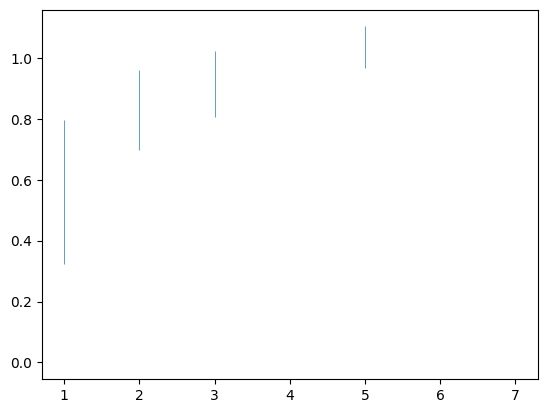

In [145]:
plt.errorbar([1,2,3,4,5,6,7], [0.56052419,0.82919958,0.91451734,0,1.03496606,0,0], yerr=[0.23667922,0.13243617,0.10752278,0.,0.0680997,0.,0.], linestyle='',
                            marker=None,
                            mew=0,
                            lw=.5,
                            zorder=0,)

In [161]:
print("Importing table...")
PlotDiffCoords(diffTables)
PlotDiffOffsets(diffTables)
PlotDiffGals(diffTables)
print("Done.")

Importing table...
Plotting coordinates...


Pointings:   0%|          | 0/3 [00:00<?, ?it/s]

Coordinates:   0%|          | 0/2 [00:00<?, ?it/s]

Plots:   0%|          | 0/2 [00:00<?, ?it/s]

Galaxies:   0%|          | 0/149 [00:00<?, ?it/s]

/tmp/ipykernel_4717/1234152721.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(


Filters:   0%|          | 0/7 [00:00<?, ?it/s]

Galaxies:   0%|          | 0/149 [00:00<?, ?it/s]

Filters:   0%|          | 0/7 [00:00<?, ?it/s]

Plots:   0%|          | 0/2 [00:00<?, ?it/s]

Galaxies:   0%|          | 0/149 [00:00<?, ?it/s]

Filters:   0%|          | 0/7 [00:00<?, ?it/s]

Galaxies:   0%|          | 0/149 [00:00<?, ?it/s]

Filters:   0%|          | 0/7 [00:00<?, ?it/s]

Filters:   0%|          | 0/7 [00:00<?, ?it/s]

Exception: You asked me to stop.

In [136]:
plt.close("all")

# plt.plot(Spectrum["Wavelength"], Spectrum["Flux"])
# plt.plot(Filter["Wavelength"], Filter["Throughput"] * 10 **(-13))
plt.plot(Filter_grid, Filter_conv * 10 ** (-13), color="green")
plt.plot(Filter_grid, Spectrum_flux, color="blue")
plt.plot(Filter_grid, Filter_conv * Spectrum_flux, color="red")

NameError: name 'Filter_grid' is not defined